In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [14]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [15]:
len(words)

32033

In [16]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [17]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
	X, Y = [], []

	for w in words:
		context = [0] * block_size
		for ch in w + '.':
			ix = stoi[ch]
			X.append(context)
			Y.append(ix)
			context = context[1:] + [ix] # crop and append

	X = torch.tensor(X)
	Y = torch.tensor(Y)
	print(X.shape, Y.shape)
	return X, Y

import random

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

torch.Size([182560, 3]) torch.Size([182560])
torch.Size([22813, 3]) torch.Size([22813])
torch.Size([22773, 3]) torch.Size([22773])


In [32]:
# MLP
n_embd = 10
n_hidden = 200

C = torch.randn((vocab_size, n_embd))
W1 = torch.randn((n_embd * block_size, n_hidden))
b1 = torch.randn(n_hidden)
W2 = torch.randn((n_hidden, vocab_size)) * 0.01
b2 = torch.randn(vocab_size) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
	p.requires_grad = True

11897


In [33]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

	# minibatch construct
	ix = torch.randint(0, Xtr.shape[0], (batch_size,))
	Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

	# forward pass
	emb = C[Xb] # embed the characters into vectors
	embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
	hpreact = embcat @ W1 + b1 # hidden layer pre-activation
	h = torch.tanh(hpreact) # hidden layer
	logits = h @ W2 + b2 # output layer
	loss = F.cross_entropy(logits, Yb) # loss function

	# backward pass
	for p in parameters:
		p.grad = None
	loss.backward()

	# update 
	lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
	for p in parameters:
		p.data += -lr * p.grad

	# track status
	if i % 10000 == 0: # print every once in a while
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())

	break


      0/ 200000: 3.3154


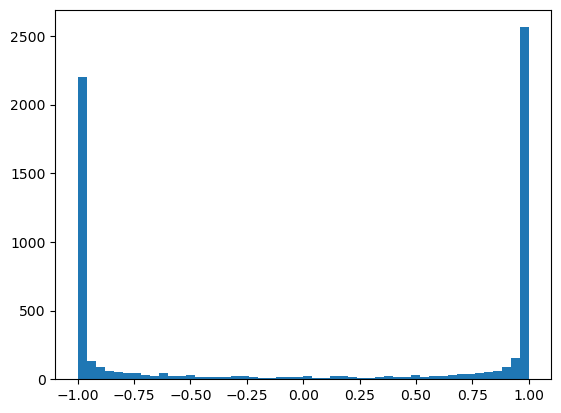

In [36]:
plt.hist(h.view(-1).tolist(), 50);

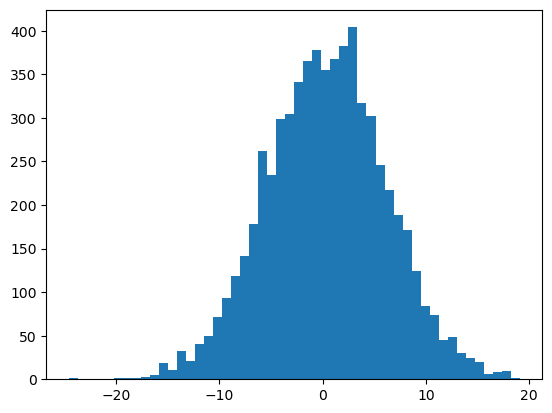

In [37]:
plt.hist(hpreact.view(-1).tolist(), 50);

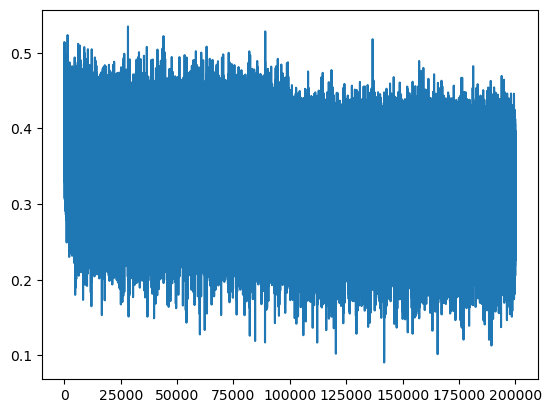

In [30]:
plt.plot(lossi)

In [31]:
@torch.no_grad()
def split_loss(split):
	x, y = {
		'train': (Xtr, Ytr),
		'val': (Xdev, Ydev),
		'test': (Xte, Yte)
	}[split]
	emb = C[x] # (N, block_size, n_embd)
	embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
	h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
	logits = h @ W2 + b2 # (N, vocab_size)
	loss = F.cross_entropy(logits, y)
	print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0719668865203857
val 2.1367950439453125


In [10]:
# sample from the model
for _ in range(20):
    
	out = []
	context = [0] * block_size

	while True:
		# forward pass the neural net
		emb = C[torch.tensor([context])] # (1, block_size, n_embd)
		h = torch.tanh(emb.view(1, -1) @ W1 + b1)
		logits = h @ W2 + b2
		probs = F.softmax(logits, dim=1)
		# sample from the distribution
		ix = torch.multinomial(probs, num_samples=1).item()
		# shift the context window and track the samples
		context = context[1:] + [ix]
		out.append(ix)
		# if we sample the special '.' token, break
		if ix == 0:
			break
	
	print(''.join(itos[i] for i in out))

saida.
nzeyera.
mareena.
sam.
asl.
yper.
samar.
padque.
vain.
nayia.
damyla.
lecto.
samarqueas.
madia.
arnisa.
xal.
nah.
mackestale.
jenni.
avio.
